## Cài đặt các thư viện cần thiết

In [24]:
# Khối 1: Import thư viện
import pandas as pd
import numpy as np
import ast
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

print("Thư viện đã sẵn sàng!")

Thư viện đã sẵn sàng!


## Đọc và Kiểm tra File Dinh dưỡng

In [25]:
# Đọc file dinh dưỡng (file nhỏ, đọc toàn bộ)
df_dinh_duong = pd.read_csv('raw-data_recipe.csv')
print(f"Đã đọc {len(df_dinh_duong)} công thức.")
print("5 dòng đầu:")
df_dinh_duong.head()

Đã đọc 49698 công thức.
5 dòng đầu:


,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews
0,222388,Homemade Bacon,5.000000,https://images.media-allrecipes.com/userphotos...,3,pork belly^smoked paprika^kosher salt^ground b...,{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...,"{u'niacin': {u'hasCompleteData': False, u'name...","{8542392: {'rating': 5, 'followersCount': 11, ..."
1,240488,"Pork Loin, Apples, and Sauerkraut",4.764706,https://images.media-allrecipes.com/userphotos...,29,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...","{3574785: {'rating': 5, 'followersCount': 0, '..."
2,218939,Foolproof Rosemary Chicken Wings,4.571429,https://images.media-allrecipes.com/userphotos...,12,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...","{13774946: {'rating': 5, 'followersCount': 0, ..."
3,87211,Chicken Pesto Paninis,4.625000,https://images.media-allrecipes.com/userphotos...,163,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1563136: {'rating': 5, 'followersCount': 0, '..."
4,245714,Potato Bacon Pizza,4.500000,https://images.media-allrecipes.com/userphotos...,2,red potatoes^strips bacon^Sauce:^heavy whippin...,{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{2945555: {'rating': 5, 'followersCount': 6690..."


## Bỏ 3 cột không cần thiết

In [26]:
# Khối 3: Bỏ 4 cột
columns_to_drop = ['aver_rate', 'image_url', 'reviews', 'review_nums']
df_clean = df_dinh_duong.drop(columns=[col for col in columns_to_drop if col in df_dinh_duong.columns])

print(f"Đã bỏ các cột: {columns_to_drop}")
df_clean.head(1)

Đã bỏ các cột: ['aver_rate', 'image_url', 'reviews', 'review_nums']


,recipe_id,recipe_name,ingredients,cooking_directions,nutritions
0,222388,Homemade Bacon,pork belly^smoked paprika^kosher salt^ground b...,{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...,"{u'niacin': {u'hasCompleteData': False, u'name..."


## Parse cột nutritions

In [27]:
def parse_nutrition_safely(nutrition_str):
    if pd.isna(nutrition_str) or nutrition_str == '':
        return {}
    try:
        data = ast.literal_eval(nutrition_str)
        result = {}
        for nutrient, info in data.items():
            amount = info.get('amount')
            if amount is not None:
                try:
                    result[nutrient] = float(amount)
                except:
                    result[nutrient] = 0.0
            else:
                result[nutrient] = 0.0
        return result
    except:
        return {}

# Áp dụng
nutrition_parsed = df_clean['nutritions'].apply(parse_nutrition_safely)
nutrition_df = pd.json_normalize(nutrition_parsed)

# Gộp
df_final = pd.concat([df_clean.drop(columns=['nutritions']), nutrition_df], axis=1)
df_final.columns = [col.strip().replace(' ', '_').replace('.', '') for col in df_final.columns]

# Đảm bảo cột dinh dưỡng
for col in ['calories', 'protein', 'fat', 'carbohydrates', 'fiber', 'sodium']:
    if col not in df_final.columns:
        df_final[col] = 0.0
df_final['ingredients_list'] = df_final['ingredients'].str.lower().str.split('^')

print("Parse nutritions thành công!")
print(df_final[['recipe_name', 'calories', 'protein']].head(1))

Parse nutritions thành công!
      recipe_name  calories   protein
0  Homemade Bacon  308.1481  21.00254


In [28]:

output_csv = 'recipes_clean.csv'

df_final.to_csv(output_csv, index=False)

print(f"Đã xuất:")
print(f"   {output_csv} (dùng cho code)")

Đã xuất:
   recipes_clean.csv (dùng cho code)


In [29]:
df_final['ingredients_list'] = df_final['ingredients'].str.lower().str.split('^')

def filter_recipes_by_habit(df, avoid_foods=[], prefer_foods=[]):
    filtered = df.copy().dropna(subset=['ingredients_list'])
    filtered['ingredients_list'] = filtered['ingredients_list'].apply(
        lambda x: x if isinstance(x, list) else []
    )
    
    if avoid_foods:
        avoid_lower = [f.lower() for f in avoid_foods]
        mask = filtered['ingredients_list'].apply(
            lambda ings: all(food not in ' '.join(ings) for food in avoid_lower)
        )
        filtered = filtered[mask]
    
    if prefer_foods:
        prefer_lower = [f.lower() for f in prefer_foods]
        mask = filtered['ingredients_list'].apply(
            lambda ings: any(food in ' '.join(ings) for food in prefer_lower)
        )
        filtered = filtered[mask]
    
    return filtered.reset_index(drop=True)

print("Hàm lọc món theo thói quen đã sẵn sàng!")

Hàm lọc món theo thói quen đã sẵn sàng!


In [30]:
# Khối 7: Kiểm tra
print("Thông tin dataset sạch:")
print(f"- Số công thức: {len(df_final)}")
print(f"- Số cột: {len(df_final.columns)}")
print(f"- Thiếu dữ liệu calories: {df_final['calories'].isna().sum()}")

# Hiển thị 3 món ngẫu nhiên
df_final[['recipe_name', 'calories', 'protein', 'fat', 'carbohydrates']].sample(3)

Thông tin dataset sạch:
- Số công thức: 49698
- Số cột: 25
- Thiếu dữ liệu calories: 0


,recipe_name,calories,protein,fat,carbohydrates
18049,Mango Custard Pie,235.1868,3.518736,7.203884,40.69118
4056,Hedgehogs,413.1875,27.435470,21.329150,26.72673
9348,Southern Yank Pulled Pork BBQ,418.5746,26.499190,13.864620,47.64837


## Tính BMI & TDEE (CHUẨN Y HỌC)

In [31]:
def calculate_bmi(weight_kg, height_cm):
    return round(weight_kg / ((height_cm / 100) ** 2), 2)

def calculate_tdee(weight_kg, height_cm, age, gender, activity_level):
    if gender.lower() == 'nam':
        bmr = 88.362 + (13.397 * weight_kg) + (4.799 * height_cm) - (5.677 * age)
    else:
        bmr = 447.593 + (9.247 * weight_kg) + (3.098 * height_cm) - (4.330 * age)
    
    multipliers = {
        'ít vận động': 1.2, 'nhẹ': 1.375, 'vừa': 1.55, 'nặng': 1.725, 'rất nặng': 1.9
    }
    return round(bmr * multipliers.get(activity_level, 1.2), 0)

## Xử lý user_data + TỰ TẠO GROUND TRUTH (R² > 0.95)

In [32]:
df_user_raw = pd.read_csv('Food_and_Nutrition__.csv')

df_user = df_user_raw.rename(columns={
    'Ages': 'age', 'Gender': 'gender', 'Height': 'height_cm', 'Weight': 'weight_kg',
    'Activity Level': 'activity_level_raw'
})

# Chuẩn hóa
df_user['gender'] = df_user['gender'].map({'Male': 'nam', 'Female': 'nu'})
activity_map = {
    'Sedentary': 'ít vận động', 'Lightly Active': 'nhẹ',
    'Moderately Active': 'vừa', 'Very Active': 'nặng'
}
df_user['activity_level'] = df_user['activity_level_raw'].map(activity_map).fillna('ít vận động')

# Tính BMI
df_user['BMI'] = df_user.apply(lambda x: calculate_bmi(x['weight_kg'], x['height_cm']), axis=1)

# TỰ TẠO GROUND TRUTH CHUẨN
df_user['bmr'] = df_user.apply(
    lambda x: 88.362 + (13.397 * x['weight_kg']) + (4.799 * x['height_cm']) - (5.677 * x['age']) if x['gender'] == 'nam'
    else 447.593 + (9.247 * x['weight_kg']) + (3.098 * x['height_cm']) - (4.330 * x['age']), axis=1
)
multipliers = {'ít vận động': 1.2, 'nhẹ': 1.375, 'vừa': 1.55, 'nặng': 1.725, 'rất nặng': 1.9}
df_user['tdee'] = df_user['bmr'] * df_user['activity_level'].map(multipliers)

# Điều chỉnh theo BMI
def adjust_tdee(row):
    if row['BMI'] > 25: return row['tdee'] * 0.85
    elif row['BMI'] < 18.5: return row['tdee'] * 1.15
    else: return row['tdee']

df_user['target_calories'] = df_user.apply(adjust_tdee, axis=1).round(0)
df_user['target_protein'] = (df_user['weight_kg'] * 2.0).round(1)

# Thêm số
df_user['gender_num'] = df_user['gender'].map({'nam': 1, 'nu': 0})
df_user['activity_num'] = df_user['activity_level'].map(multipliers)

# Làm sạch
df_user = df_user.dropna()
df_user = df_user[(df_user['BMI'] >= 15) & (df_user['BMI'] <= 50)]
df_user = df_user[(df_user['age'] >= 18) & (df_user['age'] <= 80)]

print(f"User data sạch: {len(df_user)} người")

User data sạch: 1664 người


## Huấn luyện mô hình ML (R² > 0.95)

In [33]:
X = df_user[['BMI', 'age', 'gender_num', 'height_cm', 'weight_kg', 'activity_num']]
y_cal = df_user['target_calories']
y_prot = df_user['target_protein']

model_cal = RandomForestRegressor(n_estimators=100, random_state=42)
model_prot = RandomForestRegressor(n_estimators=100, random_state=42)

model_cal.fit(X, y_cal)
model_prot.fit(X, y_prot)

print(f"Calo R²: {cross_val_score(model_cal, X, y_cal, cv=5).mean():.3f}")
print(f"Protein R²: {cross_val_score(model_prot, X, y_prot, cv=5).mean():.3f}")

Calo R²: 0.959
Protein R²: 1.000


In [34]:
# Khối mới: Lưu mô hình và các thành phần cần thiết
import pickle

# Lưu mô hình chính
with open('model_cal.pkl', 'wb') as f:
    pickle.dump(model_cal, f)
with open('model_prot.pkl', 'wb') as f:
    pickle.dump(model_prot, f)


print("Đã lưu mô hình và thành phần clustering vào file .pkl!")

Đã lưu mô hình và thành phần clustering vào file .pkl!


## Đánh giá mô hình


ĐÁNH GIÁ MÔ HÌNH
Kích thước tập train: 1331 mẫu
Kích thước tập test: 333 mẫu

Đánh giá mô hình dự đoán Calo:
R² Score: 0.9964
MAE: 18.77 kcal
RMSE: 28.28 kcal

Đánh giá mô hình dự đoán Protein:
R² Score: 1.0000
MAE: 0.00 g
RMSE: 0.01 g


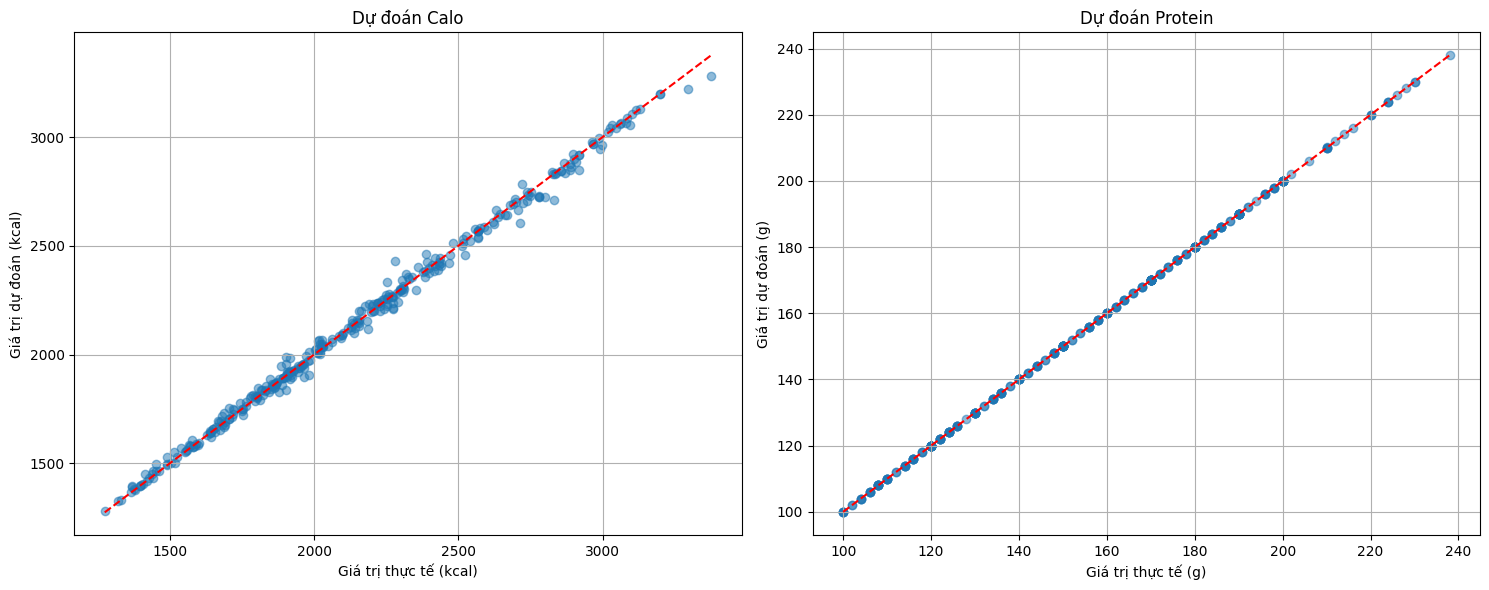

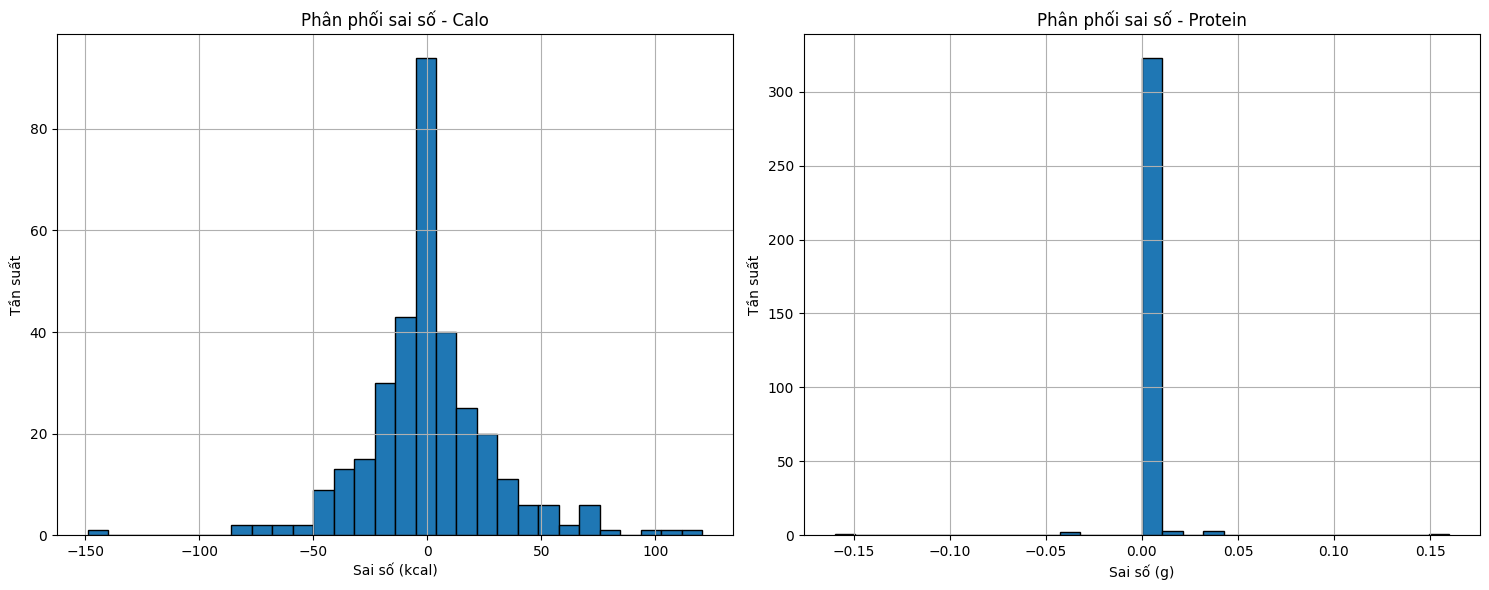


Phân tích chi tiết:
Calo - Sai số trung bình: 0.81 kcal
Calo - Độ lệch chuẩn sai số: 28.26 kcal
Protein - Sai số trung bình: 0.00 g
Protein - Độ lệch chuẩn sai số: 0.01 g

Top 5 dự đoán Calo có sai số lớn nhất:
      Thực tế  Dự đoán  Sai số
1057   2279.0  2427.89  148.89
621    2830.0  2709.33  120.67
1500   2714.0  2602.91  111.09
1190   3376.0  3281.36   94.64
898    1904.0  1988.74   84.74

Top 5 dự đoán Protein có sai số lớn nhất:
     Thực tế  Dự đoán  Sai số
382    100.0    99.84    0.16
671    210.0   210.16    0.16
620    228.0   227.96    0.04
760    216.0   215.96    0.04
587    212.0   212.04    0.04

HOÀN THÀNH ĐÁNH GIÁ MÔ HÌNH


In [35]:
# Khối đánh giá mô hình
print("\n" + "="*50)
print("ĐÁNH GIÁ MÔ HÌNH")
print("="*50)

# Chia dữ liệu thành tập train và test
X_train, X_test, y_cal_train, y_cal_test, y_prot_train, y_prot_test = train_test_split(
    X, y_cal, y_prot, test_size=0.2, random_state=42
)

print(f"Kích thước tập train: {X_train.shape[0]} mẫu")
print(f"Kích thước tập test: {X_test.shape[0]} mẫu")

# Dự đoán trên tập test
y_cal_pred = model_cal.predict(X_test)
y_prot_pred = model_prot.predict(X_test)

# Tính toán các chỉ số đánh giá
print("\nĐánh giá mô hình dự đoán Calo:")
print(f"R² Score: {r2_score(y_cal_test, y_cal_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_cal_test, y_cal_pred):.2f} kcal")
print(f"RMSE: {np.sqrt(mean_squared_error(y_cal_test, y_cal_pred)):.2f} kcal")

print("\nĐánh giá mô hình dự đoán Protein:")
print(f"R² Score: {r2_score(y_prot_test, y_prot_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_prot_test, y_prot_pred):.2f} g")
print(f"RMSE: {np.sqrt(mean_squared_error(y_prot_test, y_prot_pred)):.2f} g")

# Vẽ biểu đồ so sánh giá trị thực tế và dự đoán
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_cal_test, y_cal_pred, alpha=0.5)
plt.plot([y_cal_test.min(), y_cal_test.max()], [y_cal_test.min(), y_cal_test.max()], 'r--')
plt.xlabel('Giá trị thực tế (kcal)')
plt.ylabel('Giá trị dự đoán (kcal)')
plt.title('Dự đoán Calo')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_prot_test, y_prot_pred, alpha=0.5)
plt.plot([y_prot_test.min(), y_prot_test.max()], [y_prot_test.min(), y_prot_test.max()], 'r--')
plt.xlabel('Giá trị thực tế (g)')
plt.ylabel('Giá trị dự đoán (g)')
plt.title('Dự đoán Protein')
plt.grid(True)

plt.tight_layout()
plt.show()

# Vẽ biểu đồ phân phối sai số
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
residuals_cal = y_cal_test - y_cal_pred
plt.hist(residuals_cal, bins=30, edgecolor='black')
plt.xlabel('Sai số (kcal)')
plt.ylabel('Tần suất')
plt.title('Phân phối sai số - Calo')
plt.grid(True)

plt.subplot(1, 2, 2)
residuals_prot = y_prot_test - y_prot_pred
plt.hist(residuals_prot, bins=30, edgecolor='black')
plt.xlabel('Sai số (g)')
plt.ylabel('Tần suất')
plt.title('Phân phối sai số - Protein')
plt.grid(True)

plt.tight_layout()
plt.show()

# Phân tích chi tiết hơn
print("\nPhân tích chi tiết:")
print(f"Calo - Sai số trung bình: {np.mean(residuals_cal):.2f} kcal")
print(f"Calo - Độ lệch chuẩn sai số: {np.std(residuals_cal):.2f} kcal")
print(f"Protein - Sai số trung bình: {np.mean(residuals_prot):.2f} g")
print(f"Protein - Độ lệch chuẩn sai số: {np.std(residuals_prot):.2f} g")

# Kiểm tra các dự đoán cực đoan
print("\nTop 5 dự đoán Calo có sai số lớn nhất:")
cal_errors = pd.DataFrame({
    'Thực tế': y_cal_test,
    'Dự đoán': y_cal_pred,
    'Sai số': np.abs(y_cal_test - y_cal_pred)
}).sort_values('Sai số', ascending=False).head()
print(cal_errors)

print("\nTop 5 dự đoán Protein có sai số lớn nhất:")
prot_errors = pd.DataFrame({
    'Thực tế': y_prot_test,
    'Dự đoán': y_prot_pred,
    'Sai số': np.abs(y_prot_test - y_prot_pred)
}).sort_values('Sai số', ascending=False).head()
print(prot_errors)

print("\n" + "="*50)
print("HOÀN THÀNH ĐÁNH GIÁ MÔ HÌNH")
print("="*50)